In [331]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [332]:
import numpy as np
import polars as pl
import torch
import matplotlib.pyplot as plt

KS Statistic: 0.031178232395600802
P-value: 0.013


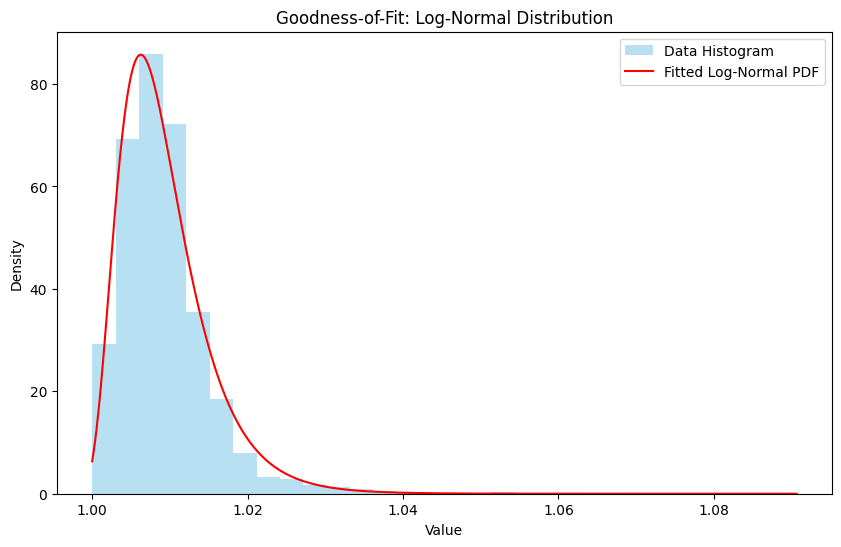

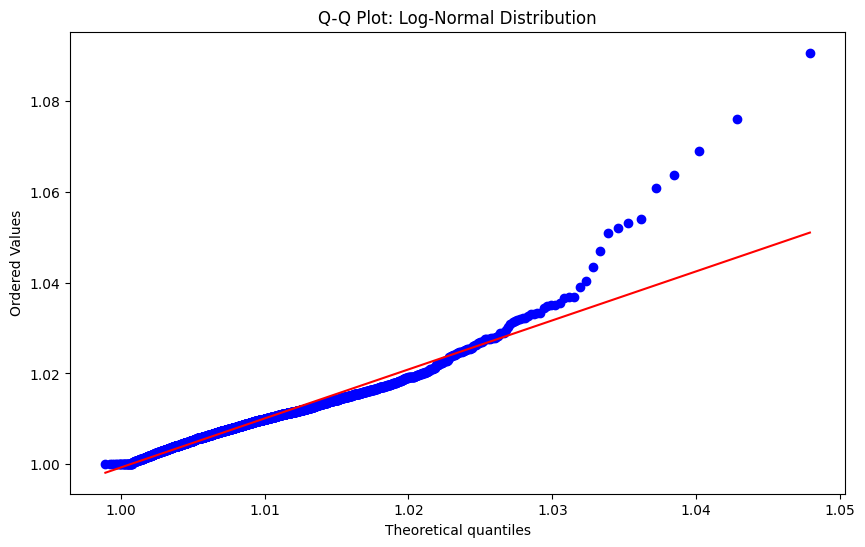

In [333]:
from data import load_data, prepare_data
from config import CATEGORICAL_COLUMNS

species = "oak"

df = load_data(species)

# Prepare data
X, y = prepare_data(
    df,
    restrict_features=[
        "defoliation_max",
        "defoliation_min",
        "defoliation_mean",
        "defoliation_median",
    ],
    plotting=True,
)

In [334]:
# One-hot encode categorical columns
import torch.nn.functional as F


def normalize(
    data: pl.DataFrame, target: pl.DataFrame
) -> tuple[F.Tensor, F.Tensor, list[str]]:
    # Impute missing values with mean
    data = data.fill_null(strategy="mean")

    # Convert to tensor
    X = data.to_torch().to(torch.float32)
    y = target.to_torch().to(torch.float32).view(-1, 1)

    # Perform one-hot encoding of categorical columns
    cols: list[str] = []
    features: list[torch.tensor] = []

    for i, col in enumerate(data.columns):
        if col in CATEGORICAL_COLUMNS:
            num_classes = data[col].n_unique()

            features.extend([f"{col}_{i}" for i in range(num_classes)])
            cols.append(F.one_hot(X[:, i].to(torch.int64), num_classes=num_classes))
        else:
            features.append(col)
            cols.append(X[:, i].unsqueeze(1))

    X = torch.cat(cols, dim=1)

    assert X.shape[1] == len(features)
    assert X.shape[0] == y.shape[0]

    # Normalize datas
    return (X - X.mean(axis=0)) / X.std(axis=0), (y - y.mean()) / y.std(), features


X, y_true, features = normalize(X, y)
X = X.nan_to_num(0.0)

assert not torch.isnan(X).any(), "Input contains NaNs"
assert not torch.isinf(X).any(), "Input contains Inf"
assert not torch.isnan(y_true).any(), "Target contains NaNs"
assert not torch.isinf(y_true).any(), "Target contains Inf"

X.shape, y_true.shape

(torch.Size([2596, 4]), torch.Size([2596, 1]))

In [335]:
# Train/test split
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(X, y_true, groups=df["tree_id"]))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_true[train_idx], y_true[test_idx]

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]
assert X_test.shape[1] == X_train.shape[1]
assert y_test.shape[1] == y_train.shape[1]
assert y_test.shape[1] == 1

In [336]:
# Create simple MLP model
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import r2_score


class MLP(nn.Module):
    def __init__(
        self, input_dim: int, hidden_dims: tuple[int, int, int], dropout: float = 0.0
    ):
        super(MLP, self).__init__()

        self.dropout0 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.dropout3 = nn.Dropout(dropout)
        self.fc4 = nn.Linear(hidden_dims[2], 1)

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x


class Linear(nn.Module):
    def __init__(self, input_dim: int):
        super(Linear, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        return self.fc(x)


model = Linear(X.shape[1])
# model = MLP(X.shape[1], (32, 16, 8), dropout=0.2)
print(f"# parameters: {sum(p.numel() for p in model.parameters())}")
print(f"# samples: {len(df)}")
print(f"# features: {len(features)}")
print(f"# train samples: {len(train_idx)}")
print(f"# test samples: {len(test_idx)}")

# Define batch size
batch_size = 256
num_epochs = 200

# Define loss and optimizer
criterion = nn.MSELoss()

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model and keep track of losses
train_loss_mean = []
train_loss_std = []
test_loss_mean = []
test_r2_scores = []


for epoch in range(num_epochs):
    # Create mini-batches
    indices = torch.randperm(X_train.shape[0])

    mini_batch_losses = []
    for i in range(0, X_train.shape[0], batch_size):
        batch_indices = indices[i : i + batch_size]
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]

        # Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

        # Average loss over mini-batches
        mini_batch_losses.append(loss.item())

    # Compute mean and standard deviation of the train loss
    train_loss_mean.append(np.mean(mini_batch_losses))
    train_loss_std.append(np.std(mini_batch_losses))

    # Compute loss and R2 score on the test set
    with torch.no_grad():
        y_pred = model(X_test)
        test_loss = criterion(y_pred, y_test)
        r2 = r2_score(y_test.numpy(), y_pred.numpy())

        test_loss_mean.append(test_loss.item())
        test_r2_scores.append(r2)

        # Save model if it has the best R2 score
        if r2 == max(test_r2_scores):
            torch.save(model.state_dict(), "best_model.pth")

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch}"
            f" - Loss: {train_loss_mean[-1]:.4f} +/- {train_loss_std[-1]:.4f}"
            f" - Test Loss: {test_loss_mean[-1]:.4f}"
            f" - Test R2: {test_r2_scores[-1]:.4f}"
        )

# parameters: 5
# samples: 2596
# features: 4
# train samples: 2089
# test samples: 507
Epoch 0 - Loss: 2.0917 +/- 0.2254 - Test Loss: 2.0075 - Test R2: -0.9815
Epoch 10 - Loss: 1.5178 +/- 0.1518 - Test Loss: 1.4607 - Test R2: -0.4418
Epoch 20 - Loss: 1.1706 +/- 0.1885 - Test Loss: 1.1699 - Test R2: -0.1548
Epoch 30 - Loss: 1.0717 +/- 0.0721 - Test Loss: 1.0396 - Test R2: -0.0261
Epoch 40 - Loss: 1.0006 +/- 0.0164 - Test Loss: 0.9938 - Test R2: 0.0191
Epoch 50 - Loss: 1.0173 +/- 0.1361 - Test Loss: 0.9812 - Test R2: 0.0315
Epoch 60 - Loss: 0.9774 +/- 0.0494 - Test Loss: 0.9790 - Test R2: 0.0337
Epoch 70 - Loss: 0.9765 +/- 0.0800 - Test Loss: 0.9785 - Test R2: 0.0342
Epoch 80 - Loss: 0.9986 +/- 0.1087 - Test Loss: 0.9780 - Test R2: 0.0346
Epoch 90 - Loss: 0.9637 +/- 0.0434 - Test Loss: 0.9771 - Test R2: 0.0356
Epoch 100 - Loss: 0.9811 +/- 0.0541 - Test Loss: 0.9769 - Test R2: 0.0357
Epoch 110 - Loss: 0.9725 +/- 0.0503 - Test Loss: 0.9760 - Test R2: 0.0366
Epoch 120 - Loss: 0.9711 +/- 0.

In [337]:
# Predict on the entire dataset
with torch.no_grad():
    y_pred = model(X_test)

    # Calculate final loss and R2 score
    loss = criterion(y_pred, y_test)
    r2 = r2_score(y_test.numpy(), y_pred.numpy())

    print(f"Score for species {species}")
    print(f"Final loss: {loss.item():.4f}")
    print(f"R2 score: {r2:.4f}")

Score for species oak
Final loss: 0.9723
R2 score: 0.0402


Text(0.5, 1.0, 'Training Loss')

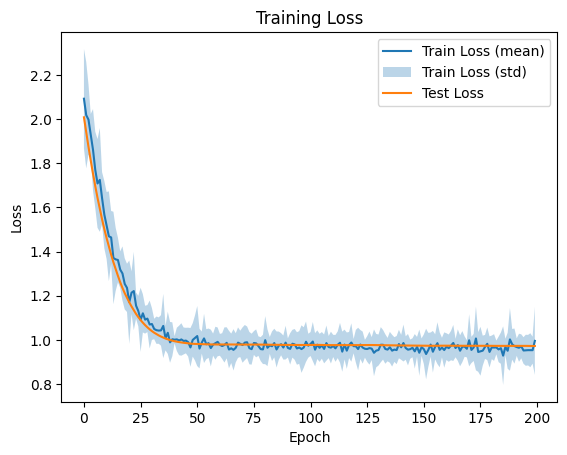

In [338]:
# Plot train losses
plt.plot(train_loss_mean)
plt.fill_between(
    range(len(train_loss_mean)),
    np.array(train_loss_mean) - np.array(train_loss_std),
    np.array(train_loss_mean) + np.array(train_loss_std),
    alpha=0.3,
)

# Plot test losses
plt.plot(test_loss_mean)

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend(["Train Loss (mean)", "Train Loss (std)", "Test Loss"])

plt.title("Training Loss")

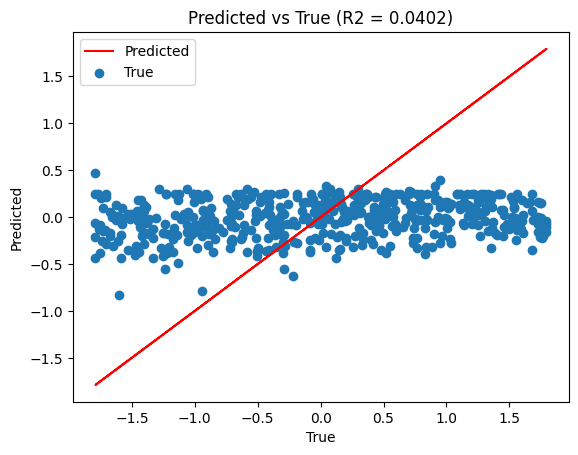

In [339]:
# Show predictions
plt.plot(y_test, y_test, color="red")
plt.scatter(y_test, y_pred)
plt.xlabel("True")
plt.ylabel("Predicted")

r2 = r2_score(y_test.numpy(), y_pred.numpy())
plt.title(f"Predicted vs True (R2 = {r2:.4f})")

plt.legend(["Predicted", "True"])

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 2089, number of used features: 4
[LightGBM] [Info] Start training from score -0.008212


/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


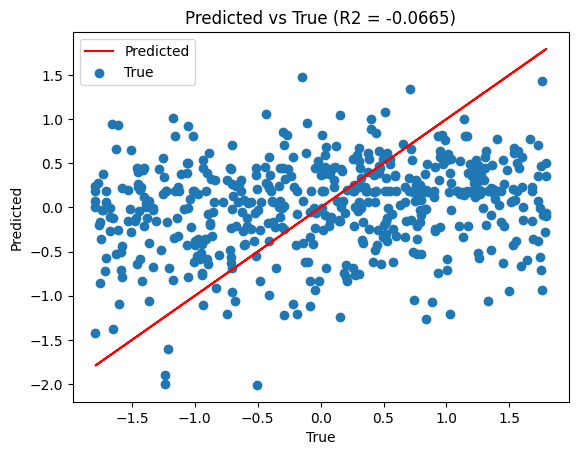

In [340]:
from lightgbm import LGBMRegressor

# Train a LightGBM model
model = LGBMRegressor(n_estimators=1000)
model.fit(X_train.numpy(), y_train.numpy())

y_pred = model.predict(X_test.numpy())

# Calculate loss
r2 = r2_score(y_test, y_pred)
plt.title(f"Predicted vs True (R2 = {r2:.4f})")

# Plot predictions
plt.plot(y_test, y_test, color="red")
plt.scatter(y_test, y_pred)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.legend(["Predicted", "True"])